In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# toy problem

# two users, two items, each user and item are represented using two parameters

toy_users = np.array([[0.6,-1],[0.5,-0.3]])
toy_items = np.array([[0.5,-0.5],[0.8,0.1]])

print("users: \n%s " %toy_users)
print("items: \n%s" %toy_items)

rates = toy_users.dot(toy_items.T)

print("ratings: \n%s" %rates)


users: 
[[ 0.6 -1. ]
 [ 0.5 -0.3]] 
items: 
[[ 0.5 -0.5]
 [ 0.8  0.1]]
ratings: 
[[ 0.8   0.38]
 [ 0.4   0.37]]


In [3]:
# how to deal with missing ratings

a = np.array([1,2,0,0,0])
print a.mean()
am = np.ma.masked_where(a == 0, a) # mark all zeros in a as masked
print am.mean()
print am.sum()
print am

b = np.array([0,1,2,3,4])
bm = np.ma.masked_where(b == 0, b)
print np.ma.dot(am,bm)

0.6
1.5
3
[1 2 -- -- --]
2


In [4]:
%cd Project/ml-100k
%ls

/Users/Ke/Google Drive/Bit-tiger-AI-Engineer/DS1704/Week3/Project/ml-100k
README             u.genre            u2.base            u5.test
allbut.pl*         u.info             u2.test            ua.base
itemFeature.csv    u.item             u3.base            ua.test
mku.sh*            u.occupation       u3.test            ub.base
ratings_test.csv   u.user             u4.base            ub.test
ratings_train.csv  u1.base            u4.test            user_test.csv
u.data             u1.test            u5.base            user_train.csv


In [5]:
!head u.data

196	242	3	881250949
186	302	3	891717742
22	377	1	878887116
244	51	2	880606923
166	346	1	886397596
298	474	4	884182806
115	265	2	881171488
253	465	5	891628467
305	451	3	886324817
6	86	3	883603013


In [6]:
names = ['user_id','item_id','rating','timestamp']

In [7]:
df = pd.read_csv('u.data',sep='\t',names=names)

In [8]:
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [9]:
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
print str(n_users) + ' users'
print str(n_items) + ' items'

943 users
1682 items


In [10]:
#create a rating matrix
ratings = np.zeros([n_users, n_items])

In [11]:
for r in df.itertuples():
    ratings[r[1]-1,r[2]-1] = r[3]
ratings[:10, :10]

array([[ 5.,  3.,  4.,  3.,  3.,  5.,  4.,  1.,  5.,  3.],
       [ 4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 4.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 4.,  0.,  0.,  0.,  0.,  0.,  2.,  4.,  4.,  0.],
       [ 0.,  0.,  0.,  5.,  0.,  0.,  5.,  5.,  5.,  4.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  5.,  4.,  0.,  0.,  0.],
       [ 4.,  0.,  0.,  4.,  0.,  0.,  4.,  0.,  4.,  0.]])

In [12]:
ratings.nonzero()

(array([  0,   0,   0, ..., 942, 942, 942]),
 array([   0,    1,    2, ..., 1187, 1227, 1329]))

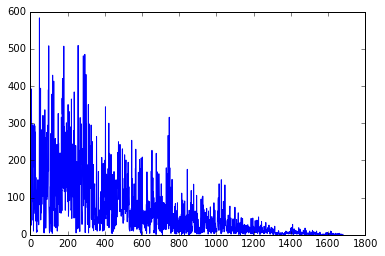

In [13]:
plt.plot((ratings>0).sum(axis=0)) # number of raings for each movie

In [14]:
ratings[10:, 10:]

array([[ 2.,  2.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  5.,  5., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 4.,  5.,  0., ...,  0.,  0.,  0.]])

In [15]:
def train_test_generation(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    #for each user
    for user in xrange(ratings.shape[0]):
        # pick 10 ratings randomly from each user
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        # set the ratings in training to be zero
        train[user, test_ratings] = 0.
        # set the ratings in the test to be the real value
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [16]:
train, test = train_test_generation(ratings)
train = np.ma.masked_where(train == 0, train) # ignore zeros in computation
test = np.ma.masked_where(test == 0, test)

In [17]:
len(train.nonzero()[0])

90570

In [18]:
len(test.nonzero()[0])

9430

In [19]:
len(ratings.nonzero()[0])

100000

In [20]:
# using MAE for evaluation
# mean absolute error
from sklearn.metrics import mean_absolute_error

# pred and actual are matrices of N by p
# actual can be test or training, depending on whether you are trying to 
# compute the test error or training error
def get_mae(pred, actual):
    # only compute on non-zero terms
    pred = pred[actual.nonzero()].flatten() 
    actual = actual[actual.nonzero()].flatten()
    return mean_absolute_error(pred, actual)

In [21]:
def myPlot(pred, actual):
    # pred here is the whole matrix, but we need to use the actual data to find the test part
    # actual is the test set, which is also a matrix
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    plt.plot(actual, pred, 'ro')
    plt.xlabel("actual")
    plt.ylabel("prediction")
    plt.xlim([0,6])
    plt.show()

In [22]:
# baseline model, use user's rating average for prediction
user_bias = train.mean(axis=1) 
# the average rating from each user, what the the possible worse value you can get here?

print user_bias[:5]

prediction_baseline = np.zeros(test.shape) + user_bias[:,np.newaxis] 
print 'Baseline model MAE: ' + str(get_mae(prediction_baseline, test))

[3.595419847328244 3.730769230769231 2.8181818181818183 4.571428571428571
 2.8484848484848486]
Baseline model MAE: 0.846699298822


In [23]:
# first part, user-based and item-based collaborative filtering
from sklearn.metrics.pairwise import cosine_similarity

# similarity matrix is always symmetric
# symmetric along diagonal, here we only still fill in zeros, 
# since the cosine_similarity can't recognize the masked value.
# if we really want to make it work, need to implement a special similarity function 
def similarity(ratings, kind='user'):
    if kind == 'user':
        sim = cosine_similarity(ratings) 
        #cosine_similarity, treat one row as one data point
        # sim is a N by N matrix
        assert(sim.shape[0] == ratings.shape[0])
    elif kind == 'item':
        sim = cosine_similarity(ratings.T)
        # sim is a p by p matrix
        assert(sim.shape[0] == ratings.shape[1])
    sim[np.isnan(sim)] = 0 # when could nan happen? think about it 
    np.fill_diagonal(sim,0) # when compute neighbors, we don't need to compute itself
    return sim

In [24]:
user_similarity = similarity(train, kind='user')
item_similarity = similarity(train, kind='item')
print user_similarity[:4, :4]
print item_similarity[:4, :4]

[[ 0.          0.12154943  0.05347659  0.05050922]
 [ 0.12154943  0.          0.10788234  0.17616817]
 [ 0.05347659  0.10788234  0.          0.37261648]
 [ 0.05050922  0.17616817  0.37261648  0.        ]]
[[ 0.          0.40010574  0.32046982  0.45440814]
 [ 0.40010574  0.          0.27160272  0.46928479]
 [ 0.32046982  0.27160272  0.          0.30582881]
 [ 0.45440814  0.46928479  0.30582881  0.        ]]


In [25]:
print user_similarity.max()
print user_similarity.mean()
print user_similarity.min()

print item_similarity.max()
print item_similarity.mean()
print item_similarity.min()

# consine similarity always report positive value or 0

0.785573011946
0.143577435504
0.0
1.0
0.0857158518059
0.0


In [26]:
np.nonzero(np.ma.getmask(train.mean(axis=0))) # we have two items without any ratings

(array([1200, 1235, 1617, 1625, 1652, 1664, 1670]),)

In [27]:
user_similarity.shape

(943, 943)

In [28]:
# prediction function
# use all ratings, including zero
def predict(ratings, similarity, kind='user'):
    if kind == 'user':
        user_bias = ratings.mean(axis=1)
        ratings = (ratings - user_bias[:, np.newaxis]).copy()
        # in case there is a whole column or row with zero, 
        # i.e. this user/item is not similar to any others, add a small number 
        
        # similarity is a matrix of N by N, row i is the similarity of user i to all other people
        # ratings is a matrix of N by p (centralized already), column k is the ratings from all the people for item k 
        # for one row of similarity dot product with one column of rating,
        # we compute the sum of the weighted ratings for all neighbors for user i, "sum(sim(k,n)*r_ni)"
        # this value, divided by the sum of all the similarities for user i, and added back the user_bias
        # will be the pred(i, k)
        
        pred = np.ma.dot(similarity, ratings) / np.array([np.abs(similarity).sum(axis=1)+1e-6]).T
        pred += user_bias[:, np.newaxis]
        
    elif kind == 'item':
        item_bias = ratings.mean(axis=0)
        ratings = (ratings - item_bias[np.newaxis, :]).copy()
        pred = np.ma.dot(ratings, similarity) / np.array([np.abs(similarity).sum(axis=1)+1e-6])
        pred += item_bias[np.newaxis, :]
    
    return pred


User-based CF train MAE: 0.791725811119
Item-based CF train MAE: 0.766526617638
User-based CF test MAE: 0.817107180821
Item-based CF test MAE: 0.825446310247


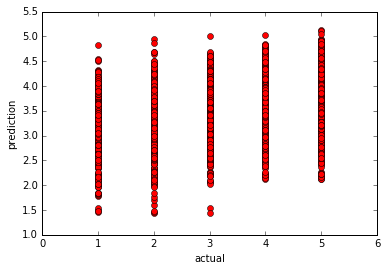

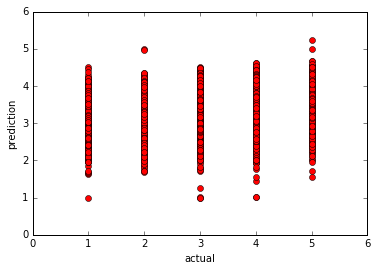

In [29]:
user_prediction = predict(train, user_similarity, kind='user')
item_prediction = predict(train, item_similarity, kind='item')

print 'User-based CF train MAE: ' + str(get_mae(user_prediction, train))
print 'Item-based CF train MAE: ' + str(get_mae(item_prediction, train))
print 'User-based CF test MAE: ' + str(get_mae(user_prediction, test))
print 'Item-based CF test MAE: ' + str(get_mae(item_prediction, test))
myPlot(user_prediction, test)
myPlot(item_prediction, test)

In [30]:
user_sim_nearest_neighbor = user_similarity.copy()
user_sim_nearest_neighbor[user_sim_nearest_neighbor<0.30]=0

item_sim_nearest_neighbor = item_similarity.copy()
item_sim_nearest_neighbor[item_sim_nearest_neighbor<0.30]=0


User-based CF train MAE: 0.77247388961
Item-based CF train MAE: 0.734948280508
User-based CF test MAE: 0.8071350154
Item-based CF test MAE: 0.807955723523


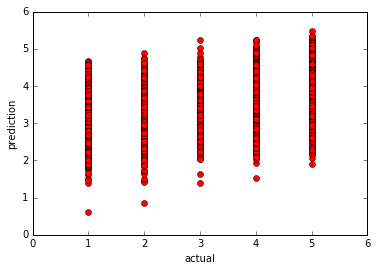

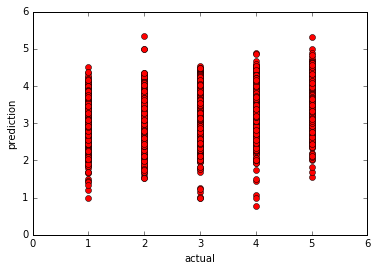

In [31]:
user_prediction = predict(train, user_sim_nearest_neighbor, kind='user')
item_prediction = predict(train, item_sim_nearest_neighbor, kind='item')

print 'User-based CF train MAE: ' + str(get_mae(user_prediction, train))
print 'Item-based CF train MAE: ' + str(get_mae(item_prediction, train))
print 'User-based CF test MAE: ' + str(get_mae(user_prediction, test))
print 'Item-based CF test MAE: ' + str(get_mae(item_prediction, test))
myPlot(user_prediction, test)
myPlot(item_prediction, test)

Matrix Factorization CF training MAE: 0.70627959744
Matrix Factorization CF test MAE: 0.809345016508


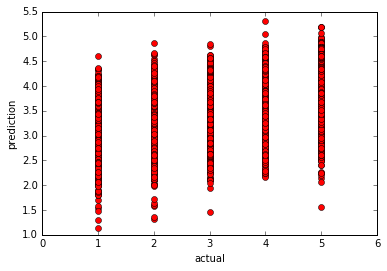

In [32]:
# **********************************************************************************************

# using SVD 
# Singular value decomposition decomposes an arbitrary matrix with three parts.
# when choosing k dimension of those parts, the result dot product is an estimation to
# the original matrix

# assume unseen ratings are all zero
# try using user mean, will it be better?

from scipy.sparse.linalg import svds # svd solver

user_ratings_mean = np.mean(train, axis = 1)
R_demeaned = train - user_ratings_mean.reshape(-1, 1)
U, sigma, Vt = svds(R_demeaned, k=10) #solve for svd, sigma is returned a vector
sigma = np.diag(sigma) # create a diagonal matrix
# dignonal matrix example
# 2 0 0
# 0 1 0 
# 0 0 0.5

# np.dot(np.dot(U, sigma), Vt) is a low rank estimation to the R_demeaned
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
print 'Matrix Factorization CF training MAE: ' + str(get_mae(all_user_predicted_ratings, train))
print 'Matrix Factorization CF test MAE: ' + str(get_mae(all_user_predicted_ratings, test))
myPlot(all_user_predicted_ratings, test)

In [33]:
def mySVD(train, test, k):
    user_ratings_mean = np.mean(train, axis = 1)
    R_demeaned = train - user_ratings_mean.reshape(-1, 1)
    U, sigma, Vt = svds(R_demeaned, k=k)
    sigma = np.diag(sigma)
    all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
    return get_mae(all_user_predicted_ratings, train), get_mae(all_user_predicted_ratings, test)

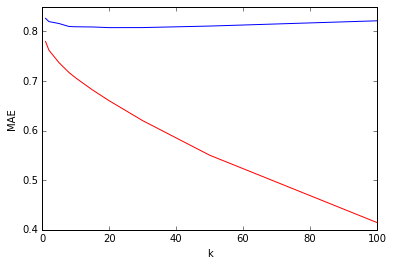

In [34]:
ks = [1,2,5,8,10,15,20,30,50,100]
train_MAEs = []
test_MAEs = []
for k in ks:
    train_MAE, test_MAE = mySVD(train, test, k)
    train_MAEs.append(train_MAE)
    test_MAEs.append(test_MAE)
plt.plot(ks, train_MAEs, 'r')
plt.plot(ks, test_MAEs, 'b')
plt.xlabel("k")
plt.ylabel("MAE")
plt.show()

In [35]:
# directly optimize the objective function, on the seen ratings
# ideally we should wait till the algorithm find a local minimum, but stop earlier sometimes
# will provide better prediction power

import numpy

#beta regularization
#alpha learning rate

def matrix_factorization(train, K, steps=10, alpha=0.0001, beta=0.02):
    N_user, N_item = train.shape
    # U and V are latent vectors
    U = numpy.random.rand(N_user,K)
    V = numpy.random.rand(N_item,K).T
    
    for step in xrange(steps):
        for i in xrange(N_user):
            for j in xrange(N_item):
                if train[i,j] > 0:
                    eij = numpy.dot(U[i,:],V[:,j]) - train[i][j]  
                    U[i] = U[i] - alpha * (2 * eij * V[:,j] + beta * U[i])
                    V[:,j] = V[:,j] - alpha * (2 * eij * U[i] + beta * V[:,j])
    
    nR = numpy.dot(U, V)
    return nR

In [36]:
K = 10

prediction_sgd = matrix_factorization(train, K=10, steps=10, alpha=0.001)


In [37]:
print 'Matrix Factorization SGD CF MAE: ' + str(get_mae(prediction_sgd, test))

Matrix Factorization SGD CF MAE: 0.803577233556


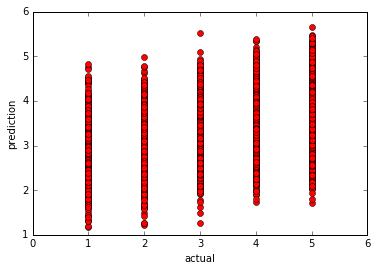

In [38]:
myPlot(prediction_sgd, test)